## Import packages

In [31]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import ERA5_functions as era_fncts
import pandas as pd
from random import randint

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [4]:
aht_ds = xr.open_dataset('aht_time_series/era5_aht_time_series.nc')

In [9]:
### Load in the necessary single lat AHT files

which_lat1 = 40
which_lat2 = -40

ddir = 'aht_time_series/one_lat/'
eddy_files1 = sorted(glob(ddir + 'eddy_total_' + str(which_lat1) +'*'))
eddy_files2 = sorted(glob(ddir + 'eddy_total_' + str(which_lat2) + '*'))

eddy_data1 = []
for eddy in eddy_files1:
    file_data = np.load(eddy)
    eddy_data1.append(file_data)

eddy_local1 = np.concatenate(eddy_data1)

eddy_data2 = []
for eddy in eddy_files2:
    file_data = np.load(eddy)
    eddy_data2.append(file_data)

eddy_local2 = np.concatenate(eddy_data2)

### Randomly sample the points

In [29]:
eddy_local1_samples = np.empty(len(eddy_local1[:,0]))
lon_samples = np.empty(720)
#For each time take a random sample at every longitude
for i in range(len(eddy_local1[:,0])):
    for j in range(720):
        lon_samples[j] = np.nanmean(np.random.choice(eddy_local1[:,j], 1))
    lon_mean = np.nanmean(lon_samples)
    eddy_local1_samples[i] = lon_mean
    
eddy_local2_samples = np.empty(len(eddy_local2[:,0]))
lon_samples = np.empty(720)
#For each time take a random sample at every longitude
for i in range(len(eddy_local2[:,0])):
    for j in range(720):
        lon_samples[j] = np.nanmean(np.random.choice(eddy_local2[:,j], 1))
    lon_mean = np.nanmean(lon_samples)
    eddy_local2_samples[i] = lon_mean

### Sample the points based on local correlations

In [34]:
#Decorrs are in grid points are degrees x2
decorr1 = 30
decorr2 = 30

eddy_local1_decor_samples = np.empty(len(eddy_local1[:,0]))
lon_samples = np.empty(720)
for i in range(len(eddy_local1[:,0])):
    for j in range(720):
        if j % decorr1 == 0: #If its the decorr length scale get a new time
            time_idx = randint(0, len(eddy_local1[:,0])-1)
        else:
            continue
        lon_samples[j] = eddy_local1[time_idx,j]
    lon_mean = np.nanmean(lon_samples)
    eddy_local1_decor_samples[i] = lon_mean
    
eddy_local2_decor_samples = np.empty(len(eddy_local2[:,0]))
lon_samples = np.empty(720)
for i in range(len(eddy_local2[:,0])):
    for j in range(720):
        if j % decorr2 == 0: #If its the decorr length scale get a new time
            time_idx = randint(0, len(eddy_local2[:,0])-1)
        else:
            continue
        lon_samples[j] = eddy_local2[time_idx,j]
    lon_mean = np.nanmean(lon_samples)
    eddy_local2_decor_samples[i] = lon_mean

### Plot it!

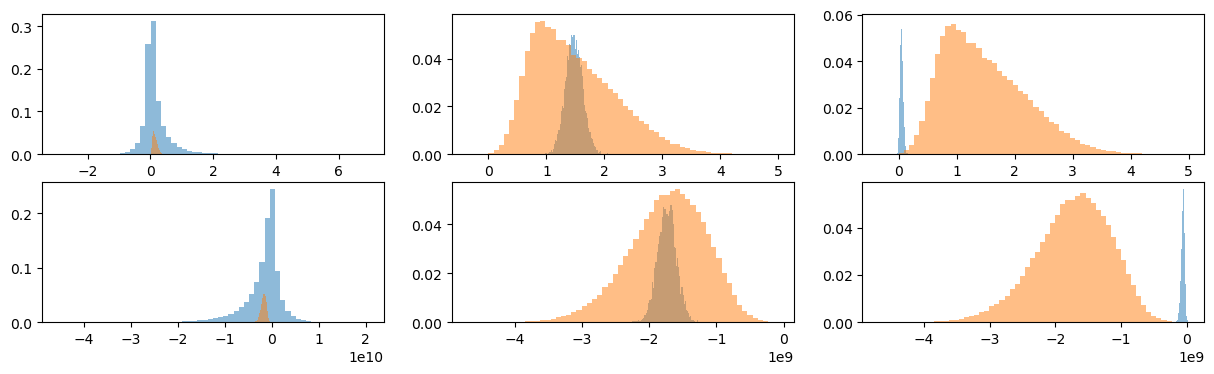

In [43]:
fig, axs = plt.subplots(2, 3, figsize=(15,4))

eddy_zonal1 = aht_ds.eddy_aht.sel(latitude=which_lat1).values.flatten()
eddy_zonal2 = aht_ds.eddy_aht.sel(latitude=which_lat2).values.flatten()

axs[0, 0].hist(eddy_local1.flatten(), weights=np.ones(len(eddy_local1.flatten())) / len(eddy_local1.flatten()), bins=60, alpha=0.5)
axs[0, 0].hist(eddy_zonal1, weights=np.ones(len(eddy_zonal1)) / len(eddy_zonal1), bins=60, alpha=0.5)

axs[1, 0].hist(eddy_local2.flatten(), weights=np.ones(len(eddy_local2.flatten())) / len(eddy_local2.flatten()), bins=60, alpha=0.5)
axs[1, 0].hist(eddy_zonal2, weights=np.ones(len(eddy_zonal2)) / len(eddy_zonal2), bins=60, alpha=0.5)

axs[0, 1].hist(eddy_local1_samples.flatten(), weights=np.ones(len(eddy_local1_samples.flatten())) / len(eddy_local1_samples.flatten()), bins=60, alpha=0.5)
axs[0, 1].hist(eddy_zonal1, weights=np.ones(len(eddy_zonal1)) / len(eddy_zonal1), bins=60, alpha=0.5)

axs[1, 1].hist(eddy_local2_samples.flatten(), weights=np.ones(len(eddy_local2_samples.flatten())) / len(eddy_local2_samples.flatten()), bins=60, alpha=0.5)
axs[1, 1].hist(eddy_zonal2, weights=np.ones(len(eddy_zonal2)) / len(eddy_zonal2), bins=60, alpha=0.5)

axs[0, 2].hist(eddy_local1_decor_samples.flatten(), weights=np.ones(len(eddy_local1_decor_samples.flatten())) / len(eddy_local1_decor_samples.flatten()), bins=60, alpha=0.5)
axs[0, 2].hist(eddy_zonal1, weights=np.ones(len(eddy_zonal1)) / len(eddy_zonal1), bins=60, alpha=0.5)

axs[1, 2].hist(eddy_local2_decor_samples.flatten(), weights=np.ones(len(eddy_local2_decor_samples.flatten())) / len(eddy_local2_decor_samples.flatten()), bins=60, alpha=0.5)
axs[1, 2].hist(eddy_zonal2, weights=np.ones(len(eddy_zonal2)) / len(eddy_zonal2), bins=60, alpha=0.5)

plt.show()

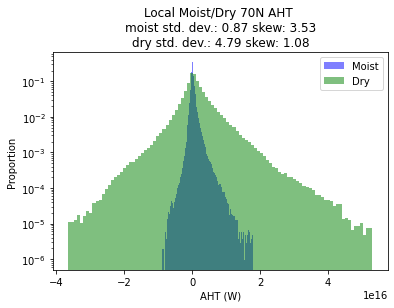

In [199]:
which_geom = geometry[era_fncts.get_lat_idx(70)]

plt.hist(which_geom * eddy_70s_moist.flatten(), weights=np.ones(len(eddy_70s_moist.flatten())) / len(eddy_70s_moist.flatten()),
         bins=100, alpha=0.5, color='b', label='Moist')
plt.hist(which_geom * eddy_70s_dry.flatten(), weights=np.ones(len(eddy_70s_moist.flatten())) / len(eddy_70s_moist.flatten()),
         bins=100, alpha=0.5, color='g', label='Dry')

moist_std = np.std(which_geom * eddy_70s_moist.flatten())
dry_std = np.std(which_geom * eddy_70s_dry.flatten())

moist_skew = sc.skew(which_geom * eddy_70s_moist.flatten())
dry_skew = sc.skew(which_geom * eddy_70s_dry.flatten())

#plt.hist(eddy_70s_moist.flatten(),  bins=30, alpha=0.5, label='Moist')
#plt.hist(eddy_70s_dry.flatten(), bins=30, alpha=0.5, label='Dry')

#plt.ylim([0, 1000])
#plt.xlim([0e10, 2e10])

plt.yscale('log')
plt.legend(loc=0)
plt.xlabel('AHT (W)')
plt.ylabel('Proportion')

plt.title('Local Moist/Dry 70N AHT \n' + 'moist std. dev.: ' + str(round(moist_std/1e15, 2)) + ' skew: ' + str(round(moist_skew, 2)) +'\n' + 'dry std. dev.: ' + str(round(dry_std/1e15, 2)) + ' skew: ' + str(round(dry_skew, 2)))

#plt.savefig('../Research_meetings/10_27_21/70n_moist_dry_local_aht_hist_logscale')

In [ ]:
ddir = 'aht_time_series/one_lat/'

file1 = ddir + 'eddy_total_70deg_all_times_1981.npy'
#file12 = ddir + 'eddy_total_40deg_all_times_1981.npy'
file2 = 'aht_time_series/moist_aht/' + 'eddy_moist_70deg_all_times_1981.npy'

eddy_zon_total = np.load('aht_time_series/eddy_all_times_1981.npy')
eddy_zon_moist = np.load('aht_time_series/moist_aht/eddy_moist_all_times_1981.npy')

eddy_local_total = np.load(file1)
eddy_local_moist = np.load(file2)

zonal_ratio = np.mean(eddy_zon_moist/eddy_zon_total, axis=0)[era_fncts.get_lat_idx(70)]

print(np.shape(eddy_local_moist))

local_ratio = np.mean(eddy_local_moist, axis=0) / np.mean(eddy_local_total, axis=0)
plt.plot(lons, local_ratio)
#plt.plot(lons, local_ratio2, label='#2')

#plt.legend(loc=0)
#plt.ylim([-5, 5])

plt.plot(range(1464), eddy_local_moist[:,0]/eddy_local_total[:,0])
print(np.mean(eddy_local_moist[:,500]/eddy_local_total[:,500]))

print(zonal_ratio)
print(np.mean(local_ratio2))

### Sampling individual point distribution to see if it re-creates zonal means

In [175]:
#First find the autocorrelation

#total_field = np.load('aht_time_series/one_lat/eddy_total_70deg_all_times_1980.npy')
#moist_field = np.load('aht_time_series/moist_aht/' + 'eddy_moist_70deg_all_times_1980.npy')
#point_field = total_field - moist_field

#point_field = np.load('aht_time_series/70deg/eddy_total_70deg_all_times_1980.npy')
#point_field = np.load('aht_time_series/one_lat/eddy_total_60deg_all_times_1980.npy')
point_field = np.load('aht_time_series/moist_aht/' + 'eddy_moist_70deg_all_times_1980.npy')
#point_field = np.load('aht_time_series/moist_aht/eddy_moist_70deg_all_times_2000.npy')

corr_coefs = np.empty((720, 720))
for i in range(720):
    for j in range(720):
        corr_coefs[i,j] = np.corrcoef(point_field[:,i], point_field[:,j])[0,1]

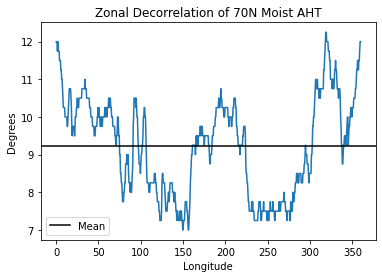

In [176]:
dummy_corr_coefs = np.zeros((720, 720))
decorrs = np.zeros(720)

for i in range(720):
    corr_coefs_point = corr_coefs[i,:]
    
    if i<360:
        dummy_corr_coefs[i,360-i:360] = corr_coefs_point[:i]
        dummy_corr_coefs[i,360:] = corr_coefs_point[i:360+i]
        dummy_corr_coefs[i,:360-i] = corr_coefs_point[i-360:]

    elif i>360:
        dummy_corr_coefs[i,:360] = corr_coefs_point[i-360:i]
        dummy_corr_coefs[i,360:360-i] = corr_coefs_point[i:]
        dummy_corr_coefs[i,360-i:] = corr_coefs_point[:i-360]
        
        
    elif i==360:
        dummy_corr_coefs[i,:] = corr_coefs_point
    else:
        print('Problem!!!')
        
    decorrs_end1 = era_fncts.find_nearest(dummy_corr_coefs[i,360:], 1/math.e)[1] + 360
    decorrs_end2 = era_fncts.find_nearest(dummy_corr_coefs[i,:360], 1/math.e)[1]
    
    idx_diff = (abs(decorrs_end1 - 360) + abs(decorrs_end2 - 360)) / 2
    
    decorrs[i] = idx_diff
    
plt.plot(lons, (decorrs / 2))
plt.axhline(np.nanmean(decorrs / 2), color='k', label='Mean')

plt.legend(loc=0)

plt.xlabel('Longitude')
plt.ylabel('Degrees')
plt.title('Zonal Decorrelation of 70N Moist AHT')

#plt.savefig('../Research_meetings/10_27_21/zonal_decorr_70n_moist')

18
18


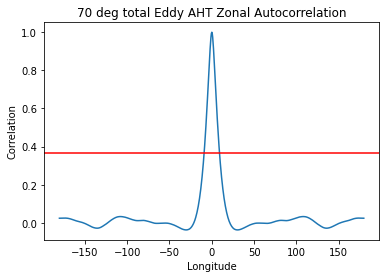

In [177]:




#Lets re-position all the corr-coefs so we can more easily average them

sum_corr_coefs = np.zeros(720)
dummy_corr_coefs = np.zeros(720)

for i in range(720):
    corr_coefs_point = corr_coefs[i,:]
    
    if i<360:
        dummy_corr_coefs[360-i:360] = corr_coefs_point[:i]
        dummy_corr_coefs[360:] = corr_coefs_point[i:360+i]
        dummy_corr_coefs[:360-i] = corr_coefs_point[i-360:]

    elif i>360:
        dummy_corr_coefs[:360] = corr_coefs_point[i-360:i]
        dummy_corr_coefs[360:360-i] = corr_coefs_point[i:]
        dummy_corr_coefs[360-i:] = corr_coefs_point[:i-360]
        
        
    elif i==360:
        dummy_corr_coefs = corr_coefs_point
    else:
        print('Problem!!!')
        
    sum_corr_coefs += dummy_corr_coefs
        
plt.plot(np.arange(-180, 180, 0.5), sum_corr_coefs/720)

plt.axhline(1/math.e, color='r')

#plt.xlim([-30, 30])
plt.title('70 deg total Eddy AHT Zonal Autocorrelation')
plt.ylabel('Correlation')
plt.xlabel('Longitude')
#plt.savefig('../Research_meetings/9_8_21/70deg_total_eddy_aht_zonal_autocorrelation')

print(era_fncts.find_nearest(sum_corr_coefs[360:]/720, 1/math.e)[1])
print(360 - era_fncts.find_nearest(sum_corr_coefs[:360]/720, 1/math.e)[1])

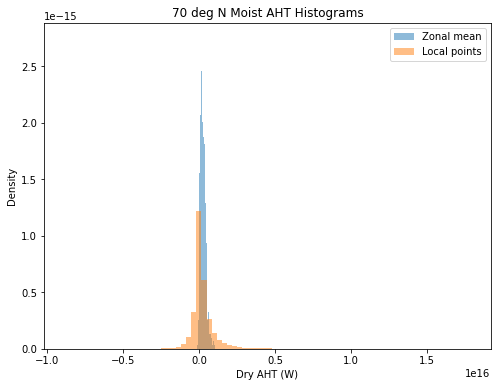

In [180]:
#point_field = np.load('aht_time_series/70deg/eddy_total_70deg_all_times_1980.npy')
#eddy_zon_int = np.load('aht_time_series/eddy_all_times_1980.npy')
point_field = np.load('aht_time_series/moist_aht/' + 'eddy_moist_70deg_all_times_1980.npy')
eddy_zon_int = np.load('aht_time_series/moist_aht/eddy_moist_all_times_1980.npy')

#total_field = np.load('aht_time_series/one_lat/eddy_total_70deg_all_times_1980.npy')
#moist_field = np.load('aht_time_series/moist_aht/' + 'eddy_moist_70deg_all_times_1980.npy')
#point_field = total_field - moist_field

#eddy_total = np.load('aht_time_series/eddy_all_times_1980.npy')
#eddy_moist = np.load('aht_time_series/moist_aht/eddy_moist_all_times_1980.npy')
#eddy_zon_int = eddy_total - eddy_moist

#Assuming no correlation between points
#samples = np.empty(1460)
#lon_samples = np.empty(720)
#for i in range(1460):
    #for j in range(720):
        #lon_samples[j] = np.nanmean(np.random.choice(point_field[:,j], 1))
    #lon_mean = np.nanmean(lon_samples)
    #samples[i] = lon_mean

samples = np.empty(1460)
lon_samples = np.empty(720)

for i in range(1460):
    for j in range(720):
        if j % 29 == 0:
            time_idx = randint(0, 1460)
        lon_samples[j] = point_field[time_idx,j]
        
    lon_mean = np.nanmean(lon_samples)
    samples[i] = lon_mean
    
plt.figure(figsize=(8,6))


plt.hist(eddy_zon_int[:,era_fncts.get_lat_idx(70)]* geometry[era_fncts.get_lat_idx(70)],
         alpha=0.5, bins=80, density=True, label='Zonal mean')

plt.hist(point_field.flatten()* geometry[era_fncts.get_lat_idx(70)],
         alpha=0.5, bins=80, density=True, label='Local points')

#plt.hist(samples * geometry[era_fncts.get_lat_idx(70)], alpha=0.5, bins=30,
         #density=True, label='Points sampled w/ decorr')

plt.legend(loc=0)

plt.ylabel('Density')
plt.xlabel('Dry AHT (W)')
plt.title('70 deg N Moist AHT Histograms')
#plt.ylim([0, .05e-15])
#plt.savefig('../Research_meetings/10_27_21/70deg_total_moist_aht_hists_points_zonal_mean')
#plt.show()